This notebook contains a personnal study of hyper parameters tuning using search algorithms.

Inspired from:
- https://scikit-learn.org/stable/modules/grid_search.html#grid-search

In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
print("Setup Complete")

Setup Complete


In [2]:
rng = np.random.RandomState(42)
print("Prayer to RNGesus Sent")

Prayer to RNGesus Sent


Let's create a synthetic dataset to plya with. Here, we use the make_moons function for a nice 2-classes classification problem.

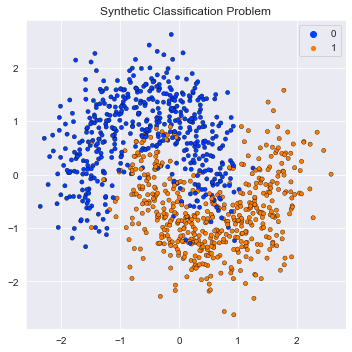

In [4]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

# for plotting in 2D space
n_features = 2
columns = ['x', 'y']

# moons
X, y = make_moons(
    n_samples=1000, random_state=rng,
    noise=0.3
)

X = StandardScaler().fit_transform(X)

# visualization
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='bright', ax=ax, size=1, edgecolor='k')
ax.set_title('Synthetic Classification Problem')
fig.tight_layout()
plt.show()

Ok, now, we want to fit this dataset with a model. We will settle for the simplest model known to us which a DecisionTreeClassifier. This will be our *estimator*.

In [5]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

We can check all the hyper-parameters used by this model:

In [6]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

The method for sampling/searching for hyper-parameters set candidates is a random parameter optimization.
As such, the explored parameter space is defined using continuous distribution for `float` parameters and arrays for others.

In [7]:
from scipy import stats

param_dist = {
#     'max_depth': np.arange(1, 10),
    'max_depth': [100,],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': stats.loguniform(1e-4, 1e-1)
}

The cross-validation scheme used is a standard 10 by 10 Stratified K Fold.

In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=10, random_state=rng
)

We can now run the randomized search:

In [9]:
from sklearn.model_selection import RandomizedSearchCV
n_iter_search = 100
random_search = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist,
    cv=cv,
    n_iter=n_iter_search,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X, y)

Fitting 100 folds for each of 100 candidates, totalling 10000 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10,
            random_state=RandomState(MT19937) at 0x1E8B5F69B40),
                   estimator=DecisionTreeClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E8B6075FD0>,
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [100]},
                   verbose=1)

In [10]:
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
].head(10)

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
0.0026096179844507434_gini_100,"{'ccp_alpha': 0.0026096179844507434, 'criterio...",1,0.9109,0.025616
0.0031529839416661967_gini_100,"{'ccp_alpha': 0.0031529839416661967, 'criterio...",2,0.9101,0.024597
0.0061203005199217874_entropy_100,"{'ccp_alpha': 0.0061203005199217874, 'criterio...",3,0.9097,0.024878
0.0034220413315354907_gini_100,"{'ccp_alpha': 0.0034220413315354907, 'criterio...",4,0.9091,0.024458
0.0057846224665216404_entropy_100,"{'ccp_alpha': 0.0057846224665216404, 'criterio...",5,0.9091,0.025616
0.0022715043637614105_gini_100,"{'ccp_alpha': 0.0022715043637614105, 'criterio...",6,0.9090,0.024759
0.004052361775221067_gini_100,"{'ccp_alpha': 0.004052361775221067, 'criterion...",7,0.9084,0.025049
0.006237137051653488_entropy_100,"{'ccp_alpha': 0.006237137051653488, 'criterion...",8,0.9084,0.025484
0.003539180638313454_gini_100,"{'ccp_alpha': 0.003539180638313454, 'criterion...",9,0.9081,0.025008


In [11]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,...,split93_test_score,split94_test_score,split95_test_score,split96_test_score,split97_test_score,split98_test_score,split99_test_score,mean_test_score,std_test_score,rank_test_score
kernel,,,,,,,,,,,,,,,,,,,,,
0.0026096179844507434_gini_100,0.002230,0.001406,0.000329,0.000469,0.00261,gini,100,"{'ccp_alpha': 0.0026096179844507434, 'criterio...",0.96,0.87,...,0.92,0.88,0.92,0.92,0.87,0.91,0.92,0.9109,0.025616,1
0.0031529839416661967_gini_100,0.002329,0.002227,0.000460,0.000555,0.003153,gini,100,"{'ccp_alpha': 0.0031529839416661967, 'criterio...",0.97,0.87,...,0.92,0.89,0.92,0.92,0.88,0.91,0.92,0.9101,0.024597,2
0.0061203005199217874_entropy_100,0.002978,0.001636,0.000611,0.001502,0.00612,entropy,100,"{'ccp_alpha': 0.0061203005199217874, 'criterio...",0.96,0.90,...,0.92,0.89,0.93,0.86,0.89,0.93,0.89,0.9097,0.024878,3
0.0034220413315354907_gini_100,0.002059,0.001384,0.000390,0.000564,0.003422,gini,100,"{'ccp_alpha': 0.0034220413315354907, 'criterio...",0.97,0.90,...,0.92,0.89,0.92,0.92,0.87,0.93,0.90,0.9091,0.024458,4
0.0057846224665216404_entropy_100,0.003099,0.002224,0.000450,0.000740,0.005785,entropy,100,"{'ccp_alpha': 0.0057846224665216404, 'criterio...",0.96,0.87,...,0.92,0.89,0.93,0.86,0.89,0.93,0.88,0.9091,0.025616,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.05190788571672514_gini_100,0.002389,0.001555,0.000520,0.001081,0.051908,gini,100,"{'ccp_alpha': 0.05190788571672514, 'criterion'...",0.92,0.87,...,0.95,0.87,0.91,0.88,0.85,0.91,0.89,0.8781,0.034862,96
0.053260397333966994_gini_100,0.002659,0.002612,0.000440,0.000553,0.05326,gini,100,"{'ccp_alpha': 0.053260397333966994, 'criterion...",0.92,0.87,...,0.95,0.87,0.91,0.88,0.85,0.91,0.89,0.8762,0.033994,97
0.09612657993909456_entropy_100,0.003259,0.003067,0.000410,0.000549,0.096127,entropy,100,"{'ccp_alpha': 0.09612657993909456, 'criterion'...",0.86,0.87,...,0.86,0.87,0.91,0.88,0.85,0.91,0.89,0.8759,0.031499,98


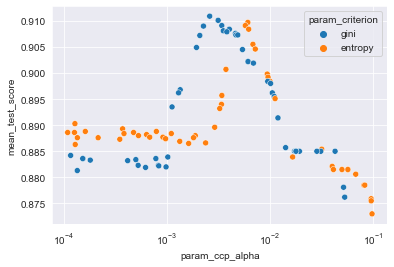

In [12]:
plt.figure()
sns.scatterplot(data=results_df, x='param_ccp_alpha', y='mean_test_score', hue='param_criterion')
plt.xscale('log')

Okay, seems like a `ccp_alpa` between 1e-3 and 1e-2 is maximizing the score for the gini criterion. We can do a finer serach on this interval using a grid search.

In [13]:
param_grid = {
    'max_depth':[100,],
    'ccp_alpha': np.linspace(1e-3, 1e-2, 100),
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator = clf, 
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y)

Fitting 100 folds for each of 100 candidates, totalling 10000 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10,
            random_state=RandomState(MT19937) at 0x1E8B5F69B40),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.001     , 0.00109091, 0.00118182, 0.00127273, 0.00136364,
       0.00145455, 0.00154545, 0.00163636, 0.00172727, 0.00181818,
       0.00190909, 0.002     , 0.00209091, 0.00218182, 0.00227273,
       0.00...
       0.00690909, 0.007     , 0.00709091, 0.00718182, 0.00727273,
       0.00736364, 0.00745455, 0.00754545, 0.00763636, 0.00772727,
       0.00781818, 0.00790909, 0.008     , 0.00809091, 0.00818182,
       0.00827273, 0.00836364, 0.00845455, 0.00854545, 0.00863636,
       0.00872727, 0.00881818, 0.00890909, 0.009     , 0.00909091,
       0.00918182, 0.00927273, 0.00936364, 0.00945455, 0.00954545,
       0.00963636, 0.00972727, 0.00981818, 0.00990909, 0.01      ]),
                         'max_depth': [100]},
             verbose=1)

In [14]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
].head(10)

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
0.0025454545454545456_100,"{'ccp_alpha': 0.0025454545454545456, 'max_dept...",1,0.9117,0.029054
0.0026363636363636363_100,"{'ccp_alpha': 0.0026363636363636363, 'max_dept...",2,0.9114,0.029665
0.0027272727272727275_100,"{'ccp_alpha': 0.0027272727272727275, 'max_dept...",3,0.9113,0.029005
0.0029090909090909093_100,"{'ccp_alpha': 0.0029090909090909093, 'max_dept...",4,0.9107,0.030241
0.002454545454545455_100,"{'ccp_alpha': 0.002454545454545455, 'max_depth...",5,0.9106,0.029659
0.0028181818181818186_100,"{'ccp_alpha': 0.0028181818181818186, 'max_dept...",6,0.9105,0.030012
0.0023636363636363638_100,"{'ccp_alpha': 0.0023636363636363638, 'max_dept...",7,0.9103,0.029579
0.003181818181818182_100,"{'ccp_alpha': 0.003181818181818182, 'max_depth...",8,0.9102,0.029664
0.003_100,"{'ccp_alpha': 0.003, 'max_depth': 100}",9,0.9102,0.029866


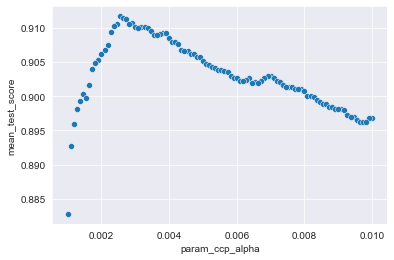

In [15]:
plt.figure()
sns.scatterplot(data=results_df, x='param_ccp_alpha', y='mean_test_score')
plt.show()

In order to be conservative, we will settle for a value of 4e-3.

In [16]:
# creating a new sample to avoid leakage moons
X, y = make_moons(
    n_samples=10000, random_state=rng,
    noise=0.3
)

from sklearn.model_selection import train_test_split

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

eval_clf = DecisionTreeClassifier(ccp_alpha=4e-3)
eval_clf.fit(X_train, y_train)


from sklearn.calibration import CalibratedClassifierCV
# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(eval_clf, cv=cv, method='isotonic')
clf_isotonic.fit(X_train, y_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]



In [17]:
prob_pos_clf = eval_clf.predict_proba(X_test)[:, 1]
order = np.argsort(prob_pos_clf)
# order = np.lexsort((prob_pos_isotonic, ))

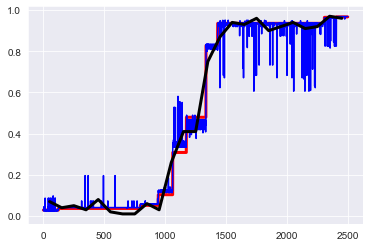

In [18]:
plt.plot(prob_pos_clf[order], 'r', lw=3)
plt.plot(prob_pos_isotonic[order], 'b')

plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')

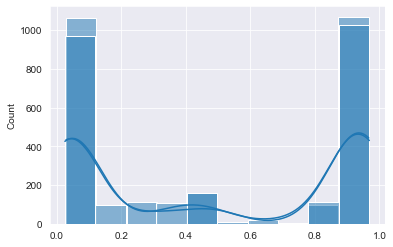

In [19]:
fig, ax = plt.subplots()
sns.histplot(prob_pos_clf, bins=10, kde=True, ax=ax)
sns.histplot(prob_pos_isotonic, bins=10, kde=True, ax=ax)
plt.show()